# NorthWind Database Project

In [282]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


Import Our Data

In [3]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

Employee = pd.read_sql_query(sql_comm[0], conn)
Category = pd.read_sql_query(sql_comm[1], conn)
Customer = pd.read_sql_query(sql_comm[2], conn)
Shipper = pd.read_sql_query(sql_comm[3], conn)

Supplier = pd.read_sql_query(sql_comm[4], conn)
Product = pd.read_sql_query(sql_comm[6], conn)
OrderDetail = pd.read_sql_query(sql_comm[7], conn)
Order = pd.read_csv('Order.csv')

CustomerCustomerDemo = pd.read_sql_query(sql_comm[8], conn)
CustomerDemographic = pd.read_sql_query(sql_comm[9], conn)
Region = pd.read_sql_query(sql_comm[10], conn)
Territory = pd.read_sql_query(sql_comm[11], conn)
EmployeeTerritory = pd.read_sql_query(sql_comm[12], conn)

In [5]:
Product.columns

Index(['Id', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued'],
      dtype='object')

In [6]:
OrderDetail.columns

Index(['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount'], dtype='object')

# Question 1: Does discount have an effect on the ammount of quantity of a product in an order? If so what level(s) of discount ?

 Null Hypothesis: H0: The average quantity of product ordered is the same with and without a discount.

Alternative Hypothesis: Ha: The average quantity of product ordered with a discount is higher or lower than orders without a discount

We begin by calculating the mean quantity per order of discount vs no discount, here we can clearly see that for all values, discounted products have a higher order quantity.

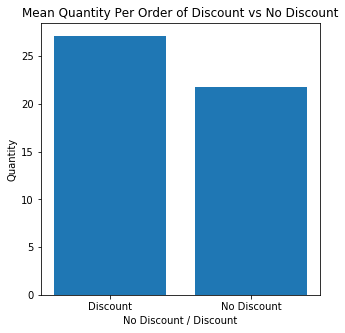

In [7]:
Y = [OrderDetail[OrderDetail['Discount'] != 0]['Quantity'].mean(), OrderDetail[OrderDetail['Discount'] == 0]['Quantity'].mean()]
X = ['Discount', 'No Discount']
plt.figure(figsize=(5,5))
plt.bar(X, Y)
plt.title('Mean Quantity Per Order of Discount vs No Discount')
plt.xlabel('No Discount / Discount')
plt.ylabel('Quantity')
plt.show()


We further investigate the assumption by plotting individual products, we can see the majority of products have a higher quantity ordered across the board when a discount is given

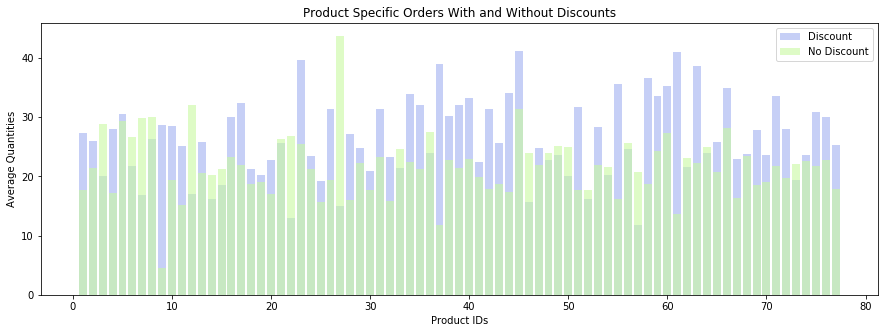

In [8]:
discount = OrderDetail[OrderDetail['Discount'] != 0].groupby('ProductId')['Quantity'].mean()
nodiscount = OrderDetail[OrderDetail['Discount'] == 0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(15,5))
plt.bar(discount.index, discount.values, alpha=.6, label = 'Discount', color = '#a0b0f0')
plt.bar(nodiscount.index, nodiscount.values, alpha=.6, label = 'No Discount', color = '#c9f9a0')
plt.legend()
plt.title('Product Specific Orders With and Without Discounts')
plt.xlabel('Product IDs')
plt.ylabel('Average Quantities')
plt.show()

Let's now run a 2-sample t-test on our samples to determine whether there is a signficant difference - enough to reject our null hypothesis

In [9]:
NoDisc = OrderDetail[OrderDetail['Discount'] != 0].copy() #Copy portion of the dataframe where discoutn does and does not = 0
Disc = OrderDetail[OrderDetail['Discount'] == 0].copy()

In [10]:
p = stats.ttest_ind(NoDisc.Quantity, Disc.Quantity)
print('p-value: {}'.format(p[1]))

p-value: 1.1440924523215966e-10


With a very small P-Value of approximately 1.144e-10 we can reject our null hypothesis as it is lower than the .05 threshold

Next we will calculate the effect size using Cohen's D, which will show us how much of an effect discount has on quantity purchased.

In [156]:
def Cohen_d(Group1, Group2):
    diff = Group1.mean() - Group2.mean()
    
    n1, n2 = len(Group1), len(Group2)
    var1 = Group1.var()
    var2 = Group2.var()
    
    pooled_var = (n1 * var1 + n2 * var2)/(n1 + n2)
    
    d = diff/np.sqrt(pooled_var)
    
    return print('Cohens D: {}'.format(d))

In [157]:
Cohen_d(NoDisc.Quantity, Disc.Quantity)

Cohens D: 0.2862724481729283


Next we will focus on the second part of our question, which is whether levels of discount have an impact on quantity purchased. We begin by formulating a new set of hypotheses.

Null Hypothesis: H0: The level of discount has no effect on the quantity sold


Alternative Hypothesis: Ha: The level of discount does have a positive or negative effect on the quantity sold. 

In [11]:
HasDisc = OrderDetail[OrderDetail['Discount'] != 0].copy() #begin by copying a new dataframe with discounts only

In [12]:
HasDisc.Discount.value_counts() #view our value counts

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

In [13]:
HasDisc['Discount'] = HasDisc['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
#since there are values with 3 or less items, we will consider them as their nearest value, which ends up with .05

In [14]:
HasDisc.Discount.value_counts() #confirm our changes took place

0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

In [15]:
Y = []
X = []
for i in HasDisc.Discount.unique():        #for loop that takes all the quantities of a certain discount and divides them by the total quantity
    AvgQuant = HasDisc.loc[HasDisc.Discount == i]['Quantity'].sum() / HasDisc.loc[HasDisc.Discount == i]['Quantity'].count()
    Y.append(AvgQuant)
    X.append(i)
X, Y = zip(*sorted(zip(X, Y)))             #reorders list so that discount values are sorted in increasing order

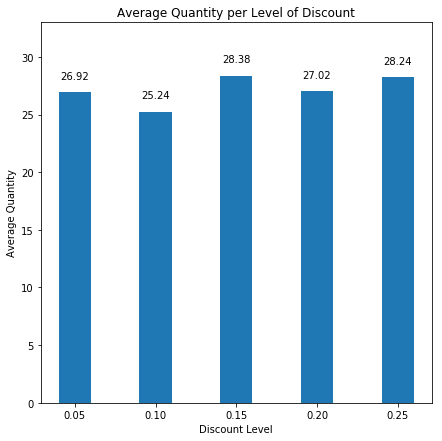

In [16]:
plt.figure(figsize=(7,7))                      # Plot Average Quantity per level of Discount
ax = plt.bar(X, Y, width=.02)
plt.title('Average Quantity per Level of Discount')
plt.ylim(0,33)
plt.xlabel('Discount Level')
plt.ylabel('Average Quantity')
patches = ax.patches 
rounded_y = []
for num in Y:
    rounded_y.append(round(num,2))
for patch, label in zip(patches,rounded_y):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width()/2, height + 1, label, ha='center', va='bottom')
plt.show()

We Will Use the ANOVA method to analyza the effect of Discount on Quantity

In [105]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, HasDisc).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                df         sum_sq     mean_sq         F    PR(>F)
C(Discount)    4.0    1065.701253  266.425313  0.616376  0.650947
Residual     833.0  360060.198508  432.245136       NaN       NaN


As we can see from our table the P value is approximately .651 which is much greater than .05, therefore we can not reject the Null Hypothesis and must state that the level of discount has no effect on the quantity purchased

The Unit Price under the Product table does not take into consideration that some prices were negotiated down, therefore the PricePaid under OrderDetail is the price after discount following a seperate negotiated price, for this we calculated the original negoatiated price and named it OriginalPrice in the OrderDetail table.

# Question 2: Is there a correlation between Discount and UnitPrice in terms of Quantity sold ?

Null Hypothesis: H0: There is no correlation between discount and unitprice in terms of quantity sold.


Alternative Hypothesis: Ha: There is a positive or negative correlation between discount and unitprice in terms of quantity sold.

In [18]:
OrderDetail['UnitPrice'].describe()

count    2155.000000
mean       26.218520
std        29.827418
min         2.000000
25%        12.000000
50%        18.400000
75%        32.000000
max       263.500000
Name: UnitPrice, dtype: float64

(array([1476.,  546.,   62.,   25.,   22.,    0.,    0.,    8.,    0.,
          16.]),
 array([  2.  ,  28.15,  54.3 ,  80.45, 106.6 , 132.75, 158.9 , 185.05,
        211.2 , 237.35, 263.5 ]),
 <a list of 10 Patch objects>)

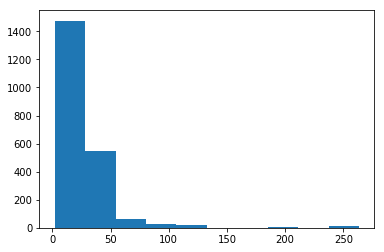

In [29]:
plt.hist(OrderDetail['UnitPrice'])

In [21]:
OrderDetailNews = OrderDetail.sort_values(by=['ProductId', 'Discount']) #sort values by product ID and Discount

In [22]:
OrderDetailNewsNO = OrderDetailNews[OrderDetailNews.Discount != 0]      #create dataframe with values with discount

In [23]:
OrderDetailNewsYES = OrderDetailNews[OrderDetailNews.Discount == 0]     #create dataframe with values without discount

In [24]:
#divide our data into 7 item groups of 11 so they may be graphed accordingly
Scatter1 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(1,11, inclusive=True)]
Scatter1a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(1,11, inclusive=True)]
Scatter2 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(12,22, inclusive=True)]  
Scatter2a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(12,22, inclusive=True)]
Scatter3 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(23,33, inclusive=True)]  
Scatter3a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(23,33, inclusive=True)]
Scatter4 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(34,44, inclusive=True)]  
Scatter4a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(34,44, inclusive=True)] 
Scatter5 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(45,55, inclusive=True)]  
Scatter5a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(45,55, inclusive=True)] 
Scatter6 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(56,66, inclusive=True)] 
Scatter6a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(56,66, inclusive=True)]  
Scatter7 = OrderDetailNewsNO.loc[OrderDetailNewsNO['ProductId'].between(67,77, inclusive=True)]  
Scatter7a = OrderDetailNewsYES.loc[OrderDetailNewsYES['ProductId'].between(67,77, inclusive=True)] 

In [25]:
ScatterPlots = (Scatter1, Scatter2, Scatter3, Scatter4, Scatter5, Scatter6, Scatter7)
ScatterPlotsb = (Scatter1a, Scatter2a, Scatter3a, Scatter4a, Scatter5a, Scatter6a, Scatter7a)
zipscat = zip(ScatterPlots, ScatterPlotsb)

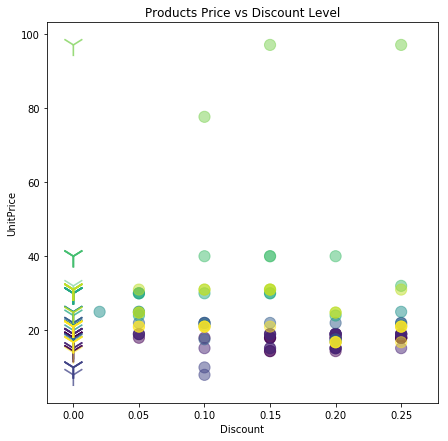

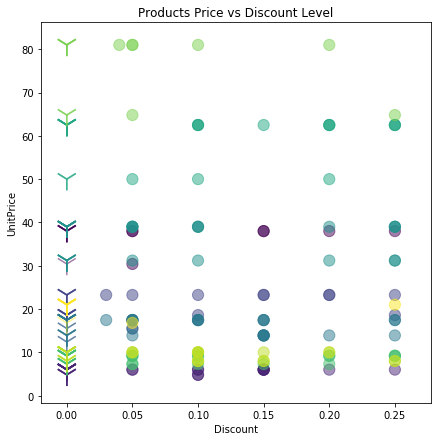

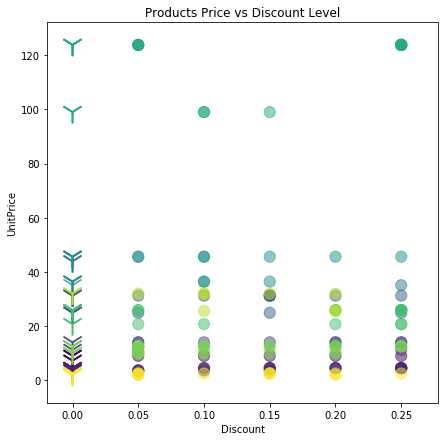

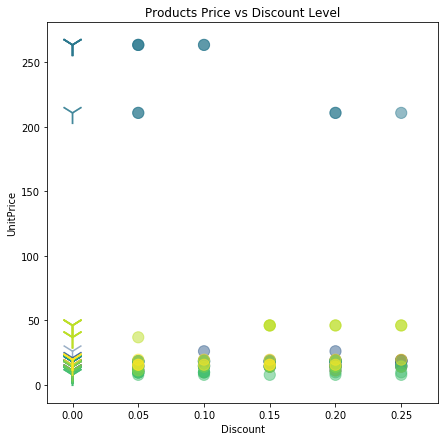

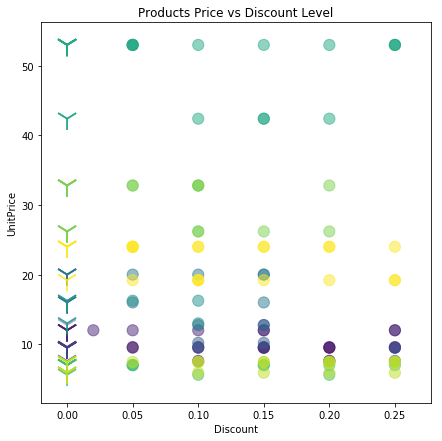

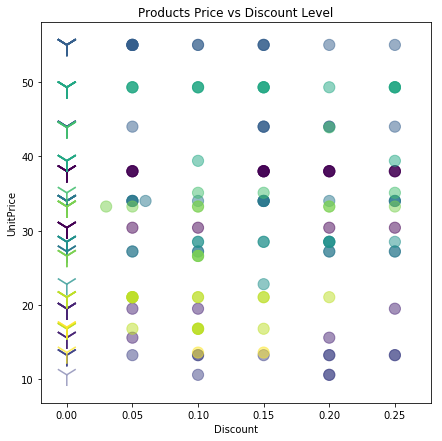

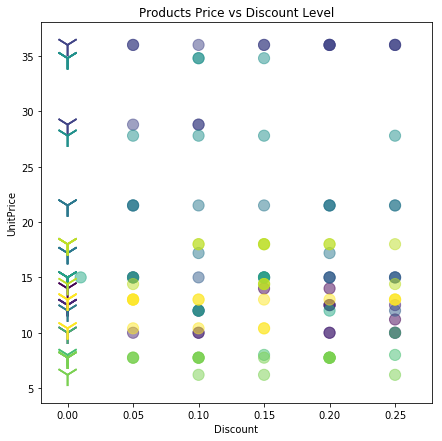

In [26]:
for a, b in zipscat:
    fig = plt.figure(figsize=(7,7))
    ax1 = fig.add_subplot(111)
    ax1.scatter(a['Discount'], a['UnitPrice'], c=a['ProductId'], marker = ".", s=500, alpha=.5)
    ax1.scatter(b['Discount'], b['UnitPrice'], c=b['ProductId'], marker = "1", s=500, alpha=.5)
    plt.xlabel('Discount')
    plt.ylabel('UnitPrice')
    plt.title('Products Price vs Discount Level')
    plt.show()

In [145]:
OrderDetailNew['Discount'] = OrderDetailNew['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
#once again reassign our discounts around .05 to .05

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Since we have a categorical variable (discount) and a continous variable (UnitPrice) we will use ANCOVA to analyze our data. 

In [146]:
formula = 'Quantity ~ C(Discount)*UnitPrice'
lm = ols(formula, OrderDetailNew).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.592
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           6.18e-07
Time:                        07:59:18   Log-Likelihood:                -9380.0
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2143   BIC:                         1.885e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        21.6653      0.692     31.297      0.000      20.308      23.023
C(Discount)[T.0.05]               5.6568      1.839      3.076      0.002       2.051       9.263
C(Discount)[T.0.1]                4.8518      1.981      2.449      0.014       0.967       8.736
C(Discount)[T.0.15]               6.3929      2.720      2.350      0.019       1.058      11.728
C(Discount)[T.0.2]                3.2313      2.154      1.500      0.134      -0.992       7.455
C(Discount)[T.0.25]               4.5212      2.241      2.018      0.044       0.127       8.916
UnitPrice                         0.0019      0.017      0.109      0.913      -0.032       0.036
C(Discount)[T.0.05]:UnitPrice    -0.0149      0.038     -0.395      0.693      -0.089       0.059
C(Discount)[T.0.1]:UnitPrice     -0.0528      0.050     -1.055      0.291      -0.151       0.045
C(Discount)[T.0.15]:UnitPrice     0.0122      0.096      0.128      0.898      -0.175       0.200
C(Discount)[T.0.2]:UnitPrice      0.0886      0.062      1.430      0.153      -0.033       0.210
C(Discount)[T.0.25]:UnitPrice     0.0709      0.056      1.270      0.204      -0.039       0.180
==============================================================================
Omnibus:                      787.916   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3092.282
Skew:                           1.769   Prob(JB):                         0.00
Kurtosis:                       7.682   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All of our P-Values for the interactions are above the .05 alpha level, therefore we can say that there is no significant correlation between discount and unit price in terms of quantity sold

# Question 3: Does Region have an effect on Quantity in an order ?

Null Hypothesis: H0: Region does not have an effect on Quantity in an order.


Alternative Hypothesis: Ha: There is a positive or negative correlation between region and quantity in an order.

In [158]:
Order.columns

Index(['Id', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry'],
      dtype='object')

In [159]:
OrderDetail.columns

Index(['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount',
       'OriginalPrice'],
      dtype='object')

In [184]:
OrderShip = Order[['ShipRegion', 'Id']]
OrderShip.columns = ['ShipRegion', 'OrderId']

In [185]:
OrderDetailQuant = OrderDetail[['OrderId', 'Quantity']]

In [189]:
RegionQuant = pd.merge(OrderShip, OrderDetailQuant)

In [190]:
RegionQuant.head()

,ShipRegion,OrderId,Quantity
0,Western Europe,10248,12
1,Western Europe,10248,10
2,Western Europe,10248,5
3,Western Europe,10249,9
4,Western Europe,10249,40


In [223]:
TotalOrders = RegionQuant.ShipRegion.value_counts()
TotalOrdersDF = pd.DataFrame({'ShipRegion':TotalOrders.index, 'NumberOrders':TotalOrders.values})
TotalOrdersDF

,ShipRegion,NumberOrders
0,Western Europe,745
1,North America,427
2,South America,355
3,British Isles,190
4,Northern Europe,143
5,Southern Europe,137
6,Central America,72
7,Scandinavia,70
8,Eastern Europe,16


In [192]:
RegionQuant.ShipRegion.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [224]:
Quantities = RegionQuant.groupby('ShipRegion')['Quantity'].sum()
QuantitiesDF = pd.DataFrame({'ShipRegion':Quantities.index, 'Quantity':Quantities.values})
QuantitiesDF

,ShipRegion,Quantity
0,British Isles,4426
1,Central America,1025
2,Eastern Europe,205
3,North America,11314
4,Northern Europe,3405
5,Scandinavia,1046
6,South America,7522
7,Southern Europe,2073
8,Western Europe,20301


In [226]:
RegOrdQua = pd.merge(TotalOrdersDF, QuantitiesDF)
RegOrdQua

,ShipRegion,NumberOrders,Quantity
0,Western Europe,745,20301
1,North America,427,11314
2,South America,355,7522
3,British Isles,190,4426
4,Northern Europe,143,3405
5,Southern Europe,137,2073
6,Central America,72,1025
7,Scandinavia,70,1046
8,Eastern Europe,16,205


In [228]:
RegOrdQua['QuantityPerOrder'] = RegOrdQua['Quantity']/RegOrdQua['NumberOrders']
RegOrdQua

,ShipRegion,NumberOrders,Quantity,QuantityPerOrder
0,Western Europe,745,20301,27.249664
1,North America,427,11314,26.496487
2,South America,355,7522,21.188732
3,British Isles,190,4426,23.294737
4,Northern Europe,143,3405,23.811189
5,Southern Europe,137,2073,15.131387
6,Central America,72,1025,14.236111
7,Scandinavia,70,1046,14.942857
8,Eastern Europe,16,205,12.812500


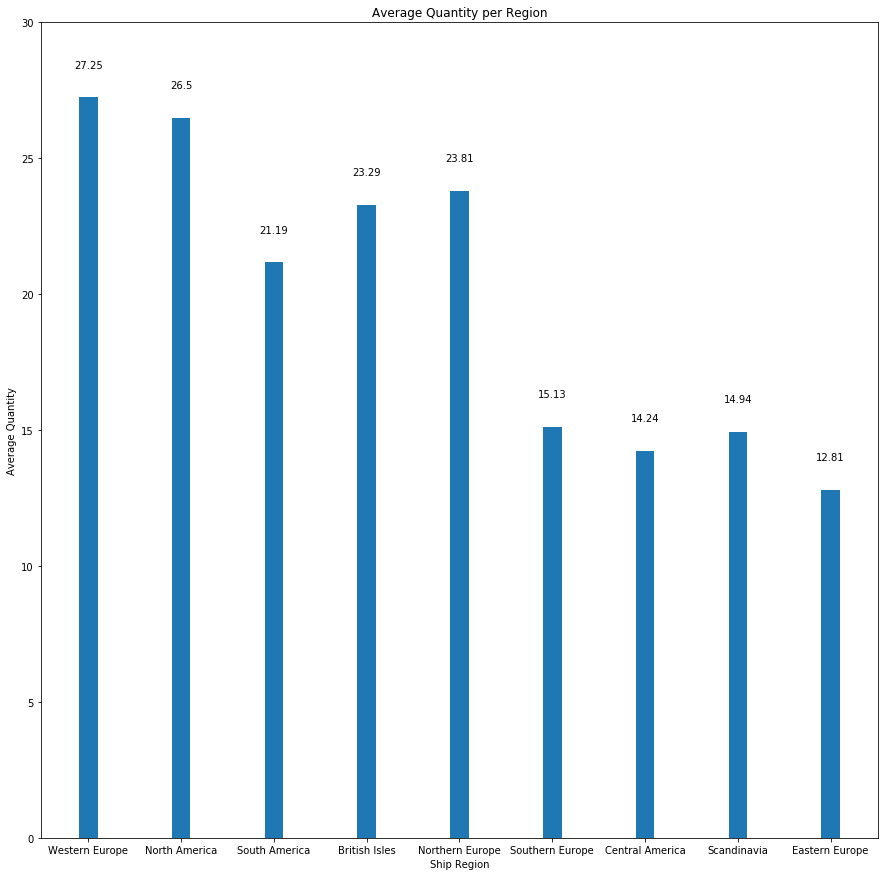

In [232]:
plt.figure(figsize=(15,15))                      # Plot Average Quantity per level of Discount
ax = plt.bar(RegOrdQua['ShipRegion'], RegOrdQua['QuantityPerOrder'], width=.2)
plt.title('Average Quantity per Region')
plt.ylim(0,30)
plt.xlabel('Ship Region')
plt.ylabel('Average Quantity')
patches = ax.patches 
rounded_y = []
for num in RegOrdQua['QuantityPerOrder']:
    rounded_y.append(round(num,2))
for patch, label in zip(patches,rounded_y):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width()/2, height + 1, label, ha='center', va='bottom')
plt.show()

In [235]:
formula = 'Quantity ~ C(ShipRegion)'
lm = ols(formula, RegionQuant).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                   df         sum_sq      mean_sq         F        PR(>F)
C(ShipRegion)     8.0   38742.747208  4842.843401  14.03179  4.668457e-20
Residual       2146.0  740656.888987   345.133685       NaN           NaN


With a P-Value of approximately 4.668e-20, which is much lower than our alpha threshold of .05, we can reject the Null Hypothesis and conclude that the Region does have a significant impact on Quantity per Order.

# Question 4: Does the Employee making the sales have a significant impact on Quantity sold in an Order ?

Null Hypothesis: H0: The Employee making the sale does not have a impact on the Quantity solid in an Order.


Alternative Hypothesis: Ha: There is a positive or negative correlation between the employee and quantity solid in an order.

In [250]:
Order1 = Order[['Id', 'EmployeeId']]

In [251]:
Order1.columns =['OrderId', 'EmployeeId']

In [256]:
Order2 = OrderDetail[['OrderId', 'Quantity']]

In [259]:
EmployeeQuant = pd.merge(Order1, Order2)
EmployeeQuant.head()

,OrderId,EmployeeId,Quantity
0,10248,5,12
1,10248,5,10
2,10248,5,5
3,10249,6,9
4,10249,6,40


In [271]:
employees = EmployeeQuant.groupby('EmployeeId')['Quantity'].mean()
employees

EmployeeId
1    22.643478
2    25.124481
3    24.461059
4    23.328571
5    25.948718
6    20.994048
7    26.443182
8    22.742308
9    24.953271
Name: Quantity, dtype: float64

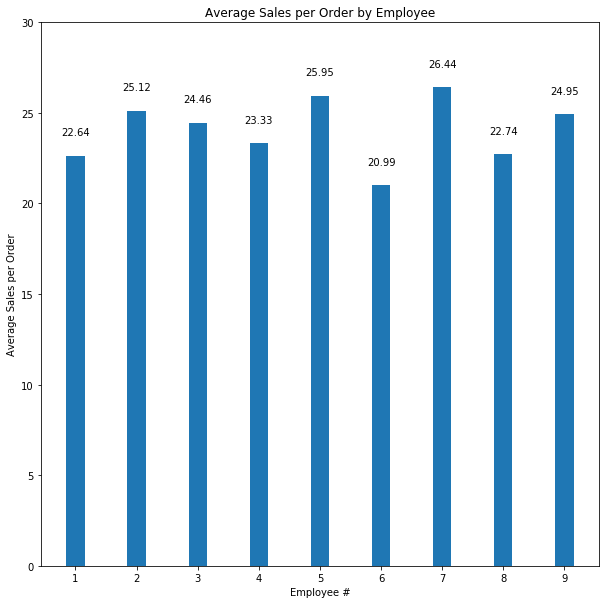

In [280]:
plt.figure(figsize=(10,10))                      # Plot Average Quantity per level of Discount
ax = plt.bar(employees.index, employees.values, width=.3)
plt.title('Average Sales per Order by Employee')
plt.ylim(0,30)
plt.xlabel('Employee #')
plt.ylabel('Average Sales per Order')
plt.xticks(employees.index)
patches = ax.patches 
rounded_y = []
for num in employees.values:
    rounded_y.append(round(num,2))
for patch, label in zip(patches,rounded_y):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width()/2, height + 1, label, ha='center', va='bottom')
plt.show()

In [281]:
formula = 'Quantity ~ C(EmployeeId)'
lm = ols(formula, EmployeeQuant).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                   df         sum_sq    mean_sq         F   PR(>F)
C(EmployeeId)     8.0    4643.183282  580.39791  1.607646  0.11745
Residual       2146.0  774756.452913  361.02351       NaN      NaN


With a P-Value of approximately .117, which is higher than our alpha threshold of .05, we cannot reject the Null Hypothesis and conclude that the Employee making the sale does not have a significant impact on Quantity per Order.

# Conclusions

Discounts are healthy for business regardless of the level of discount offered.  
Discounts on high or low priced items do not have an effect on the quantity at which their sold. 
Target regions such as Western Europe and North America as quantity sold varies by region.
Do not apply too much emphasis on employee specific strategies as all employees sell similarly. 


# Further Exploration

Do suppliers have a relationship to quantity sold?
What Categories have the greatest quantity sold ?
What time of year do the most products sell ?